In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import math
import time
import pickle
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from itertools import zip_longest
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from torch.optim import Adam, LBFGS




from model_data_class import Cus_Dataset, SimpleNN
from train_test_loop import training_loop
from sklearn.preprocessing import StandardScaler


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
np.random.seed(1234)
torch.manual_seed(1234)

Data-Preparation

In [88]:
# import .csv dataset 
file_path = "../data/heat_data.csv"
temp1 = pd.read_csv(file_path)

temp2=temp1.copy()

a = temp2.shape[0]

pp1 = np.random.uniform(low=2,high=10,size=a)

temp2['pp1']= pp1
temp2['modtemp'] = temp2['temp']* temp2['pp1']


temp3 = temp2.copy()
cols = ['x', 't', 'pp1','modtemp']
scalers = {}
for col in cols:
    scaler = MinMaxScaler()
    temp3[col] = scaler.fit_transform(temp3[[col]])
    scalers[col] = scaler





In [89]:
# Dataset Preparation

feature_columns = ['x','t','pp1']
target_column = 'modtemp'

train_dataset = Cus_Dataset(temp3,feature_columns,target_column,train_ratio=0.8,\
                                   test_ratio=0.1, val_ratio=0.1,split='train')

val_dataset = Cus_Dataset(temp3,feature_columns,target_column,train_ratio=0.8,\
                                   test_ratio=0.1, val_ratio=0.1,split='val')

test_dataset = Cus_Dataset(temp3,feature_columns,target_column,train_ratio=0.8,\
                                   test_ratio=0.1, val_ratio=0.1,split='test')


In [90]:
train_dataset.__getitem__(0)

(tensor([0.5102, 0.7644, 0.0742]), tensor(0.0791))

In [91]:
train_loader = DataLoader(train_dataset, batch_size=512,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=512,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=512,shuffle=True)

print(f"Train dataset size: {len(train_loader)}")

Train dataset size: 2459


In [92]:
# check for gpu
if torch.backends.mps.is_available():
    print("MPS is available")
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)

print('Using device:', device)

MPS is available
Using device: mps


In [93]:
input_size = 3
hidden_size = 20
output_size = 1

learning_rate = 0.005
hidden_layers = 5

epochs= 1

model = SimpleNN(input_size,hidden_size,output_size,hidden_layers)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)


In [94]:
loss_train,loss_test,best_model = training_loop(epochs,model,optimizer,train_loader,val_loader)

 
----------------------------------------------------------------------------------------------------
| Epoch 1,            | Training-Loss 3.9370e-04,| Test-Loss 1.0897e-04   |
----------------------------------------------------------------------------------------------------
 
 
----------------------------------------------------------------------------------------------------
| Epoch 1,            | Training-Loss 3.9370e-04,| Test-Loss 1.0897e-04   |
----------------------------------------------------------------------------------------------------
 


In [98]:
# Save the best model

# model_path = 'best_model.pth'
model_path = os.path.join(os.getcwd())
torch.save(best_model.state_dict(), os.path.join(model_path,"best_model.pth"))
print(f"Model saved to {model_path}")

Model saved to /Users/radhikrammohan/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/github/pinn-pc-1d/simple-nn/model


(157350,)
(157350,)
(157350, 1)
(157350, 1)
RMSE: 80.45939872848913
R2 score: 0.9981642961502075
Mean of targets: 4826.107421875


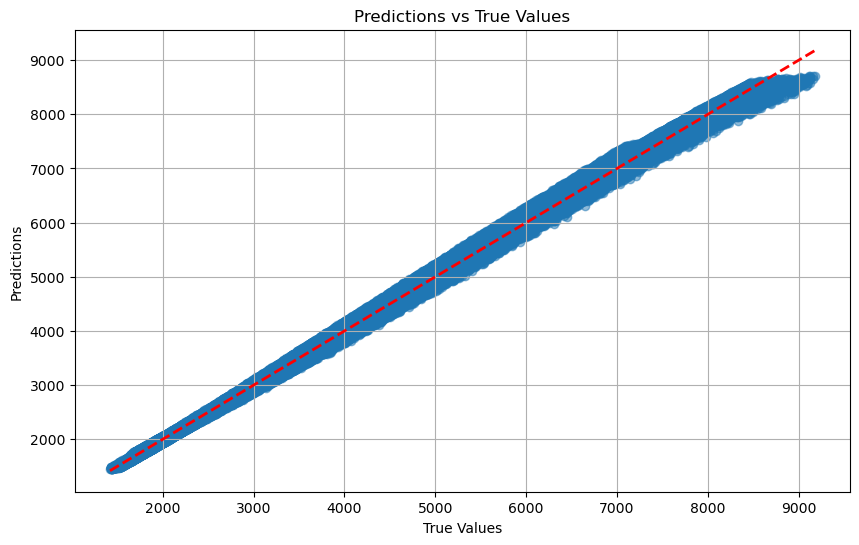

In [100]:


# Import your model class
from model_data_class import SimpleNN
model = SimpleNN(input_size, hidden_size, output_size, hidden_layers)


state_dict = torch.load(os.path.join(model_path,"best_model.pth"),weights_only=False)
model.load_state_dict(state_dict)

model.eval()
predictions = []
targets = []
model.to(device)
with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        predictions.append(pred.cpu().numpy())
        targets.append(y.cpu().numpy())
predictions = np.concatenate(predictions)
targets = np.concatenate(targets)
predictions = predictions.reshape(-1)
targets = targets.reshape(-1)
print(predictions.shape)
print(targets.shape)
# Inverse transform the predictions

predictions = scalers['modtemp'].inverse_transform(predictions.reshape(-1, 1))
targets = scalers['modtemp'].inverse_transform(targets.reshape(-1, 1))
print(predictions.shape)
print(targets.shape)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(targets, predictions))
print(f"RMSE: {rmse}")
# Calculate R2 score
from sklearn.metrics import r2_score
r2 = r2_score(targets, predictions)
print(f"R2 score: {r2}")
print(f"Mean of targets: {np.mean(targets)}")
# Plot the predictions vs targets
plt.figure(figsize=(10, 6))
plt.scatter(targets, predictions, alpha=0.5)
plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.grid()
plt.show()

